## Import all required packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
import pickle
import numpy as np

## Check GPU correctly installed

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Availables: ' ,len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Availables:  1


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17326018222806888011
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1303806822208313237
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7046801664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7110923058282310026
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:26:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8560543780740525007
physical_device_desc: "device: XLA_GPU device"
]


## Gather data

In [5]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
# Unpack the data
def load_cfar10_batch(path, batch_ids=None):
    """Function to load the data of that is provided in different batches
    Args:
        path (str): The path where the data is stored.
        batch_ids (list): list of batch ids to load into the dataset.
    Returns:
        features (array): an array of features.
        labels (array): an array of labels.
    """
    data_dict = {'features': [], 'labels': [] }
    if type(batch_ids) == int: 
        for i in range(1,batch_ids+1):

            with open(path + '/data_batch_' + str(i), mode='rb') as file:
                # note the encoding type is 'latin1'
                batch = pickle.load(file, encoding='latin1')
                data_dict['features'].extend(batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1))
                data_dict['labels'].extend(batch['labels'])
    else:
        with open(path, mode='rb') as file:
                # note the encoding type is 'latin1'
                batch = pickle.load(file, encoding='latin1')
                data_dict['features'].extend(batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1))
                data_dict['labels'].extend(batch['labels'])
    
        
    return data_dict['features'],data_dict['labels'] 
        

In [7]:
features, labels = load_cfar10_batch('.\\cifar-10-batches-py\\',5)

In [8]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
test_features, test_labels = load_cfar10_batch('.\\cifar-10-batches-py\\test_batch')
test_features = np.array((test_features))

In [10]:
# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.33, shuffle= True)

## Data pre-processing

In [11]:
train_labels = tf.keras.utils.to_categorical(
    y_train, num_classes=10, dtype='float32'
)

test_labels_cat = tf.keras.utils.to_categorical(
    test_labels, num_classes=10, dtype='float32'
)
val_labels = tf.keras.utils.to_categorical(
    y_valid, num_classes=10, dtype='float32'
)

In [12]:
np.shape(x_train)

(33500, 32, 32, 3)

In [13]:
train_batch = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow(np.array((x_train)), train_labels, shuffle=True, batch_size=64)
test_batch = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow(test_features, test_labels, shuffle=False,  batch_size=64)
validation_batch = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow(np.array((x_valid)), val_labels, shuffle=False,  batch_size=64)


In [14]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100


In [102]:
x_train[5]

array([[[204, 204, 185],
        [207, 206, 187],
        [215, 212, 192],
        ...,
        [179, 177, 146],
        [176, 176, 145],
        [175, 173, 142]],

       [[207, 204, 184],
        [212, 209, 189],
        [220, 216, 196],
        ...,
        [182, 180, 149],
        [179, 178, 147],
        [176, 173, 143]],

       [[207, 203, 182],
        [214, 210, 190],
        [222, 218, 198],
        ...,
        [182, 179, 148],
        [175, 173, 143],
        [169, 166, 135]],

       ...,

       [[178, 171, 148],
        [173, 164, 140],
        [172, 163, 135],
        ...,
        [165, 158, 126],
        [163, 157, 125],
        [162, 157, 125]],

       [[181, 173, 150],
        [173, 165, 141],
        [170, 161, 135],
        ...,
        [169, 161, 130],
        [167, 161, 128],
        [166, 160, 129]],

       [[177, 169, 146],
        [172, 165, 140],
        [169, 161, 137],
        ...,
        [167, 161, 130],
        [166, 159, 129],
        [164, 158, 129]]

In [24]:
y_train

[3,
 0,
 6,
 5,
 1,
 9,
 7,
 0,
 3,
 3,
 0,
 1,
 6,
 3,
 7,
 8,
 6,
 2,
 2,
 9,
 5,
 6,
 4,
 0,
 0,
 3,
 6,
 9,
 4,
 1,
 9,
 6,
 5,
 4,
 5,
 5,
 9,
 9,
 5,
 6,
 7,
 2,
 6,
 1,
 1,
 7,
 9,
 9,
 1,
 8,
 6,
 8,
 0,
 2,
 2,
 0,
 5,
 4,
 8,
 7,
 7,
 2,
 9,
 1,
 3,
 7,
 6,
 9,
 5,
 2,
 0,
 0,
 3,
 4,
 0,
 1,
 2,
 3,
 9,
 3,
 3,
 7,
 6,
 7,
 6,
 5,
 7,
 9,
 6,
 9,
 8,
 8,
 0,
 1,
 0,
 6,
 6,
 5,
 5,
 6,
 2,
 1,
 2,
 4,
 9,
 1,
 9,
 8,
 9,
 8,
 6,
 8,
 0,
 5,
 2,
 6,
 5,
 1,
 0,
 6,
 2,
 2,
 3,
 0,
 2,
 6,
 4,
 5,
 0,
 3,
 1,
 0,
 4,
 9,
 6,
 9,
 4,
 6,
 9,
 1,
 3,
 5,
 9,
 5,
 7,
 1,
 0,
 4,
 3,
 6,
 6,
 8,
 7,
 8,
 1,
 7,
 8,
 2,
 7,
 7,
 9,
 7,
 4,
 4,
 1,
 3,
 2,
 8,
 5,
 3,
 9,
 2,
 1,
 2,
 1,
 0,
 3,
 2,
 3,
 6,
 5,
 5,
 6,
 3,
 4,
 7,
 9,
 5,
 7,
 6,
 5,
 0,
 8,
 4,
 0,
 2,
 1,
 5,
 2,
 5,
 5,
 2,
 4,
 7,
 8,
 1,
 0,
 3,
 7,
 5,
 5,
 0,
 1,
 8,
 8,
 0,
 4,
 3,
 0,
 5,
 7,
 5,
 8,
 2,
 9,
 8,
 4,
 7,
 6,
 2,
 7,
 9,
 5,
 1,
 0,
 2,
 4,
 0,
 0,
 1,
 6,
 4,
 4,
 1,
 8,
 8,
 8,
 0,
 1,
 3,


## Model

## If model exists, load it

In [39]:
from tensorflow.keras.models import load_model
if os.path.isfile('.\\models\\custom_cifar10_model2.h5'):
    model = load_model('.\\models\\custom_cifar10_model2.h5')
    print('model loaded')

model loaded


## Add callbacks for during training

In [136]:
cb = EarlyStopping(monitor='loss', patience=3)
checkpoint_path = ".\\models"
model_cp = ModelCheckpoint(filepath=checkpoint_path,
                           save_weights_only=True,
                           monitor='val_accuracy',
                           mode='max',
                           save_best_only=True)
learning_rate=0.0001
def lr_scheduler(epoch):
    if epoch < 10:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(0.1*(10-epoch))
lr_scheduler = LearningRateScheduler(lr_scheduler)
tb_path = ".\\models"
tb_cb = TensorBoard(log_dir=tb_path)

## Create model

In [137]:
model = Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation('softmax')
  ])


In [138]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)       

In [139]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [140]:
# fits the model on batches with real-time data augmentation:
history = model.fit(train_batch, 
                    validation_data=validation_batch,
                    steps_per_epoch=len(x_train) // BATCH_SIZE,
                    epochs=100,
                    callbacks=[cb, model_cp, lr_scheduler, tb_cb],
                    verbose=2,
                   )

Epoch 1/100
523/523 - 10s - loss: 3.6796 - accuracy: 0.1975 - val_loss: 1.8935 - val_accuracy: 0.3319
Epoch 2/100
523/523 - 10s - loss: 1.8711 - accuracy: 0.3138 - val_loss: 1.6620 - val_accuracy: 0.4067
Epoch 3/100
523/523 - 9s - loss: 1.6877 - accuracy: 0.3821 - val_loss: 1.5120 - val_accuracy: 0.4568
Epoch 4/100
523/523 - 10s - loss: 1.5614 - accuracy: 0.4359 - val_loss: 1.4239 - val_accuracy: 0.4950
Epoch 5/100
523/523 - 9s - loss: 1.4757 - accuracy: 0.4670 - val_loss: 1.3634 - val_accuracy: 0.5175
Epoch 6/100
523/523 - 10s - loss: 1.3939 - accuracy: 0.4961 - val_loss: 1.3036 - val_accuracy: 0.5326
Epoch 7/100
523/523 - 10s - loss: 1.3332 - accuracy: 0.5220 - val_loss: 1.2572 - val_accuracy: 0.5602
Epoch 8/100
523/523 - 10s - loss: 1.2760 - accuracy: 0.5421 - val_loss: 1.1855 - val_accuracy: 0.5853
Epoch 9/100
523/523 - 10s - loss: 1.2162 - accuracy: 0.5628 - val_loss: 1.1503 - val_accuracy: 0.5919
Epoch 10/100
523/523 - 10s - loss: 1.1609 - accuracy: 0.5879 - val_loss: 1.1080 - va

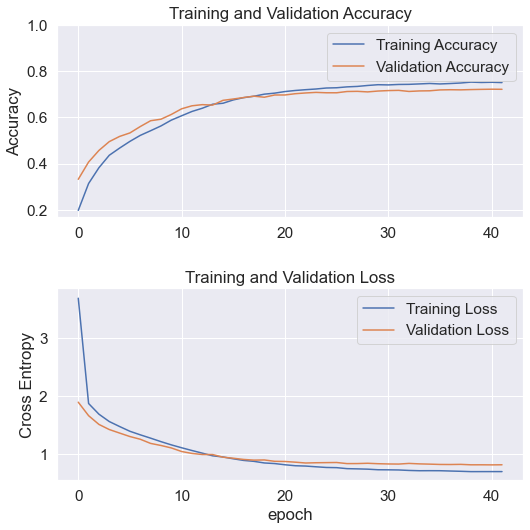

In [142]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())+0.02])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0) # spacing between plots
plt.show()

## Save this model 

In [145]:
if os.path.isfile('.\\models\\custom_cifar10_cbs.h5') is False:
    model.save('.\\models\\custom_cifar10_cbs.h5')
    

## PREDICT

In [40]:
predictions = model.predict(x=test_batch, verbose=0)

In [41]:
np.argmax(predictions[0], axis=-1)

5

In [26]:
np.round(predictions[:5])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

## Analysis

In [27]:
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(predictions, axis=-1))

In [28]:
cm

array([[761,  26,  42,  12,  11,   5,  11,  10,  64,  58],
       [  6, 866,   6,   6,   3,   5,   9,   0,  16,  83],
       [ 62,   8, 641,  44,  76,  52,  73,  22,  12,  10],
       [ 16,  10,  58, 538,  56, 162,  96,  31,   9,  24],
       [ 14,   4,  44,  55, 707,  24,  83,  49,  13,   7],
       [  6,   2,  35, 164,  43, 648,  41,  44,   5,  12],
       [  4,   5,  21,  31,  19,  10, 902,   2,   4,   2],
       [  9,   3,  26,  38,  45,  45,  17, 796,   2,  19],
       [ 40,  44,  10,   9,   2,   7,   8,   4, 843,  33],
       [  9,  50,   2,   6,   4,   3,   5,   5,  16, 900]], dtype=int64)

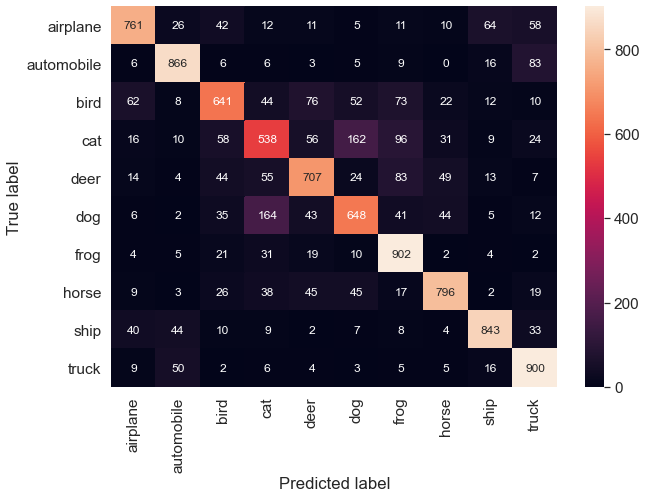

In [80]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, load_label_names(), load_label_names())
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g') # font size
ax.set(xlabel="Predicted label", ylabel="True label")
plt.show()

In [32]:
print('Confusion Matrix\n')
print(cm)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = np.argmax(predictions, axis=-1)
y_test = test_labels
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(test_labels, y_pred)))

print('Micro-averaged F1-score, calculated for total TP, FP and FN of the model.')
print('--------------------------------------------------------------------------------------')
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro-averaged F1-score, calculated for each class and returned the unweighted mean.')
print('--------------------------------------------------------------------------------------')
print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Macro-averaged F1-score, calculated for each class and returned the weighted mean.')
print('--------------------------------------------------------------------------------------')
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']))

Confusion Matrix

[[761  26  42  12  11   5  11  10  64  58]
 [  6 866   6   6   3   5   9   0  16  83]
 [ 62   8 641  44  76  52  73  22  12  10]
 [ 16  10  58 538  56 162  96  31   9  24]
 [ 14   4  44  55 707  24  83  49  13   7]
 [  6   2  35 164  43 648  41  44   5  12]
 [  4   5  21  31  19  10 902   2   4   2]
 [  9   3  26  38  45  45  17 796   2  19]
 [ 40  44  10   9   2   7   8   4 843  33]
 [  9  50   2   6   4   3   5   5  16 900]]

Accuracy: 0.76

Micro-averaged F1-score, calculated for total TP, FP and FN of the model.
--------------------------------------------------------------------------------------
Micro Recall: 0.76
Micro F1-score: 0.76

Macro-averaged F1-score, calculated for each class and returned the unweighted mean.
--------------------------------------------------------------------------------------
Macro Precision: 0.76
Macro Recall: 0.76
Macro F1-score: 0.76

Macro-averaged F1-score, calculated for each class and returned the weighted mean.
--------------

## Try Transfer Learning

In [ ]:
if os.path.isfile('.\\models\\vgg16_cifar10_model.h5'):
    model = load_model('.\\models\\vgg16_cifar10_model.h5')
    print('model loaded')

In [ ]:
model.get_weights()

In [ ]:
# This feature extractor converts each 32*32*3 image into a 1x1x1280 block of features.
# image_batch, label_batch = next(iter(train_batch))


In [33]:
# Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers
IMG_SHAPE = (32,32,3)
# create the base model
base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=IMG_SHAPE)

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [43]:
# Freeze the convolutional base
base_model.trainable = False


In [44]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [83]:


model = tf.keras.Sequential()
for layer in base_model.layers[:-1]:
    model.add(layer)

# output layer
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=10, activation="softmax", name="probs"))




In [84]:
# compile model 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [85]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

In [26]:
initial_epochs = 20
loss0, accuracy0 = model.evaluate(validation_batch)


NameError: name 'model' is not defined

In [60]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 11.32
initial accuracy: 0.08


In [86]:
history = model.fit(x=train_batch,
                    epochs=initial_epochs,
                    validation_data=validation_batch)

Epoch 1/20
  2/524 [..............................] - ETA: 14s - loss: 11.8568 - accuracy: 0.0547

o:\anaconda\envs\computervision2\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


524/524 [==============================] - 29s 56ms/step - loss: 9.6737 - accuracy: 0.1711 - val_loss: 7.3055 - val_accuracy: 0.2519
Epoch 2/20
524/524 [==============================] - 31s 59ms/step - loss: 6.7645 - accuracy: 0.3068 - val_loss: 5.2154 - val_accuracy: 0.3841
Epoch 3/20
524/524 [==============================] - 31s 58ms/step - loss: 5.2485 - accuracy: 0.4036 - val_loss: 4.2959 - val_accuracy: 0.4552
Epoch 4/20
524/524 [==============================] - 30s 57ms/step - loss: 4.4368 - accuracy: 0.4513 - val_loss: 3.7292 - val_accuracy: 0.4910
Epoch 5/20
524/524 [==============================] - 29s 56ms/step - loss: 3.8980 - accuracy: 0.4841 - val_loss: 3.2928 - val_accuracy: 0.5186
Epoch 6/20
524/524 [==============================] - 30s 58ms/step - loss: 3.4604 - accuracy: 0.5075 - val_loss: 2.9354 - val_accuracy: 0.5386
Epoch 7/20
524/524 [==============================] - 30s 58ms/step - loss: 3.0676 - accuracy: 0.5235 - val_loss: 2.6180 - val_accuracy: 0.5552
Epo

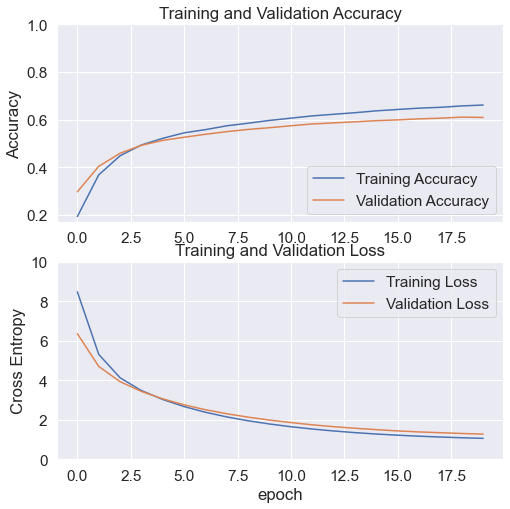

In [67]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Save this model

In [81]:
if os.path.isfile('.\\models\\vgg16_cifar10_model_vgg16_with_dropout.h5') is False:
    model.save('.\\models\\vgg16_cifar10_model_with_dropout.h5')

## Predict

In [64]:
predictions = model.predict(x=test_batch, verbose=0)

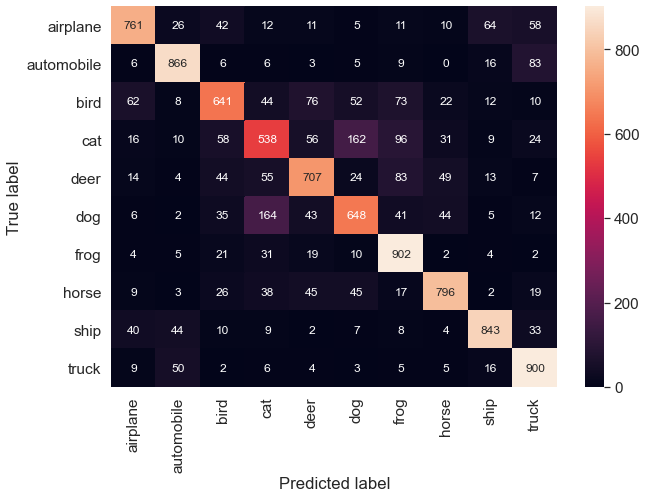

In [79]:
df_cm = pd.DataFrame(cm, load_label_names(), load_label_names())
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g') # font size
ax.set(xlabel="Predicted label", ylabel="True label")
plt.show()

In [66]:
print('Confusion Matrix\n')
print(cm)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = np.argmax(predictions, axis=-1)
y_test = test_labels
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(test_labels, y_pred)))

print('Micro-averaged F1-score, calculated for total TP, FP and FN of the model.')
print('--------------------------------------------------------------------------------------')
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro-averaged F1-score, calculated for each class and returned the unweighted mean.')
print('--------------------------------------------------------------------------------------')
print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Macro-averaged F1-score, calculated for each class and returned the weighted mean.')
print('--------------------------------------------------------------------------------------')
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']))

Confusion Matrix

[[761  26  42  12  11   5  11  10  64  58]
 [  6 866   6   6   3   5   9   0  16  83]
 [ 62   8 641  44  76  52  73  22  12  10]
 [ 16  10  58 538  56 162  96  31   9  24]
 [ 14   4  44  55 707  24  83  49  13   7]
 [  6   2  35 164  43 648  41  44   5  12]
 [  4   5  21  31  19  10 902   2   4   2]
 [  9   3  26  38  45  45  17 796   2  19]
 [ 40  44  10   9   2   7   8   4 843  33]
 [  9  50   2   6   4   3   5   5  16 900]]

Accuracy: 0.62

Micro-averaged F1-score, calculated for total TP, FP and FN of the model.
--------------------------------------------------------------------------------------
Micro Recall: 0.62
Micro F1-score: 0.62

Macro-averaged F1-score, calculated for each class and returned the unweighted mean.
--------------------------------------------------------------------------------------
Macro Precision: 0.62
Macro Recall: 0.62
Macro F1-score: 0.62

Macro-averaged F1-score, calculated for each class and returned the weighted mean.
--------------